# Image compression using KMeans

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors. By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities). In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### Load 128x128 color image (bird_small.png)

This creates a three-dimensional matrix A whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A(50, 33, 3) gives the blue intensity of the pixel at row 50 and
column 33.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io as sio

image_data = sio.loadmat('./data/bird_small.mat')
X_image = image_data['A']
dim = X_image.shape
# Reshape the image data to create a mx3 matrix of pixel colors where m is the number of pixels ( 128 * 128 )
X_image_reshaped = X_image.reshape(-1, 3)
# The mx3 numpy matrix is loaded as a dataframe
X_image_df = pd.DataFrame(X_image_reshaped, columns=['R','G','B'], dtype=np.int32)
data_columns = X_image_df.columns.values
# number of clusters ( here number of colors to paint an image )
K = 16
max_iters = 10
num_data_cols = 3

#### Display the original image

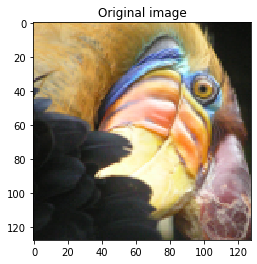

In [9]:
def display_image(image_data, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.imshow(image_data)

display_image(X_image, 'Original image')    

Select K centroids ( pixels ) randomly as initial centroids

In [4]:
def get_random_initial_centroids(X, K):
    random_indices = np.random.choice(X.shape[0], size=K)
    random_initial_centroids = X[random_indices, :]
    return random_initial_centroids

initial_centroids = get_random_initial_centroids(X_image_reshaped, K)

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the findClosestCentroids function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 by 128 pixel locations, resulting in total size of 128 by 128 by 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 * 24 + 128 * 128 * 4 = 65, 920 bits,
which corresponds to compressing the original image by about a factor of 6.

In [6]:
def find_closest_centroids(X_df, initial_centroids, num_data_cols):
    num_centroids = len(initial_centroids)
    # compute the euclidian distance of each data point from each of the centroids and store it in a 
    # column of dataframe
    for i in range(num_centroids):
        col_name = i
        initial_centroid_matrix = np.tile(initial_centroids[i], (len(X_df), 1))
        X_df[col_name] = np.sqrt(np.sum(np.square(X_df.iloc[:, 0:num_data_cols].values - initial_centroid_matrix), 
                                        axis=1))
    # for each data point ( row in dataframe ) compare the distance from each centroid and assign the data point
    # to centroid with minimum distance
    if 'cluster' in X_df.columns:
        X_df['cluster'] = X_df.iloc[:, num_data_cols:-1].idxmin(axis=1)
    else:
        X_df['cluster'] = X_df.iloc[:, num_data_cols:].idxmin(axis=1)
    return X_df

def compute_centroids(X_df, data_col_names, clusters):
    new_centroids = []
    for cluster in clusters:
        cluster_df = X_df[X_df['cluster'] == cluster]
        new_centroids.append([cluster_df[data_col_name].mean() for data_col_name in data_col_names])
    return np.array(new_centroids).astype('int32')


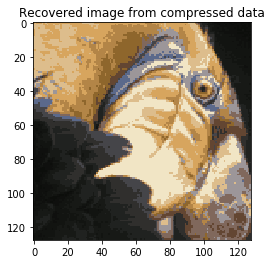

In [10]:
def run_kmeans(X_df, data_cols, initial_centroids, clusters, num_iterations):
    centroids = initial_centroids
    for iter_count in range(num_iterations):
        X_df = find_closest_centroids(X_df, centroids, len(data_cols))
        centroids = compute_centroids(X_df, data_cols, clusters)
    # the cluster column contains one of the K cluster values that each data point belongs to. In our
    # image compression example, this means that each pixel can be represent using a 16 bit short int
    # instead of the [R G B] array wherein each element represents a color intensity in 8 bits (0-255)
    # It is this compressed image representation ( a 128 by 128 array) that we return after running the kmeans
    return X_df['cluster'].values.reshape(128, 128), centroids

def uncompress_image_data(X_image_compressed, final_centroids):
    recovered_image = []
    for row in range(X_image_compressed.shape[0]):
        recovered_image_row = []
        for col in range(X_image_compressed.shape[1]):
            index = X_image_compressed[row][col]
            recovered_image_row.append(list(final_centroids[index]))
        recovered_image.append(recovered_image_row)
    return np.array(recovered_image)

X_image_reshaped = find_closest_centroids(X_image_df, initial_centroids, num_data_cols)
X_image_compressed, final_centroids = run_kmeans(X_image_reshaped, data_columns, initial_centroids, np.arange(K), max_iters)
X_image_recovered = uncompress_image_data(X_image_compressed, final_centroids)
display_image(X_image_recovered, 'Recovered image from compressed data')